# Intel Processor Recommendation System
## Content-Based Filtering with Cosine Similarity

This notebook implements a processor recommendation system using content-based filtering and cosine similarity algorithms.

**Key Features:**
- Cosine similarity for finding similar processors
- User preference matching
- Category and use-case filtering
- Interactive recommendation engine

## 1. Import Required Libraries
Import all necessary libraries for data processing, similarity calculation, and visualization.

In [71]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning and similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.precision', 3)

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


## 2. Load and Prepare the Dataset
Load the cleaned processor features dataset and perform initial exploration.

In [72]:
# Load the cleaned features dataset
df = pd.read_csv('intel_processors_features.csv')

print("📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Processors: {len(df)}")
print(f"Features: {len(df.columns)}")

print("\n📋 Categories:")
print(df['category'].value_counts())

print("\n🎯 Use Cases (Vertical Segments):")
print(df['feat.vertical_segment'].value_counts())

print("\n🔍 Sample data:")
df.head()

📊 Dataset Overview:
Shape: (148, 17)
Processors: 148
Features: 17

📋 Categories:
category
Xeon_Processors          68
Core_Ultra_Processors    44
Core_Processors          31
Xeon_Max_Processors       5
Name: count, dtype: int64

🎯 Use Cases (Vertical Segments):
feat.vertical_segment
Server      73
Mobile      35
Embedded    20
Desktop     20
Name: count, dtype: int64

🔍 Sample data:


,processor_name,category,feat.total_cores,feat.total_threads,feat.max_turbo_ghz,feat.base_freq_ghz,feat.cache_mb,feat.base_power_w,feat.turbo_power_w,feat.price_usd,feat.max_mem_gb,feat.gfx_max_dyn_ghz,feat.execution_units,feat.vertical_segment,feat.freq_per_watt,feat.cores_per_watt,feat.cache_per_core
0,Intel® Core™ 3 processor 100HL (12M Cache- up ...,Core_Processors,8,12,4.6,2.1,12.0,45.0,115.0,306.0,96.0,1.30,48.0,Embedded,0.102,0.178,1.500
1,Intel® Core™ 3 processor 100UL (10M Cache- up ...,Core_Processors,6,8,4.5,2.4,10.0,15.0,55.0,285.0,96.0,1.25,64.0,Embedded,0.300,0.400,1.667
2,Intel® Core™ 3 processor 100U (10M Cache- up t...,Core_Processors,6,8,4.7,2.4,10.0,15.0,55.0,1195.0,96.0,1.25,64.0,Mobile,0.313,0.400,1.667
3,Intel® Core™ 3 processor 100U (10M Cache- up t...,Core_Processors,6,8,4.7,2.4,10.0,15.0,55.0,1195.0,96.0,1.25,64.0,Mobile,0.313,0.400,1.667
4,Intel® Core™ 3 Processor 201EF (12M Cache- up ...,Core_Processors,4,8,4.8,2.4,12.0,35.0,115.0,1195.0,192.0,1.85,72.0,Embedded,0.143,0.400,3.000


In [73]:
# Feature analysis
feature_cols = [col for col in df.columns if col.startswith('feat.')]
print(f"🔢 Total features for similarity: {len(feature_cols)}")
print("\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")

print("\n📈 Feature statistics:")
df[feature_cols].describe().round(2)

🔢 Total features for similarity: 15

Feature list:
 1. feat.total_cores
 2. feat.total_threads
 3. feat.max_turbo_ghz
 4. feat.base_freq_ghz
 5. feat.cache_mb
 6. feat.base_power_w
 7. feat.turbo_power_w
 8. feat.price_usd
 9. feat.max_mem_gb
10. feat.gfx_max_dyn_ghz
11. feat.execution_units
12. feat.vertical_segment
13. feat.freq_per_watt
14. feat.cores_per_watt
15. feat.cache_per_core

📈 Feature statistics:


,feat.total_cores,feat.total_threads,feat.max_turbo_ghz,feat.base_freq_ghz,feat.cache_mb,feat.base_power_w,feat.turbo_power_w,feat.price_usd,feat.max_mem_gb,feat.gfx_max_dyn_ghz,feat.execution_units,feat.freq_per_watt,feat.cores_per_watt,feat.cache_per_core
count,148.00,148.00,148.00,148.00,148.00,148.0,148.00,148.00,148.00,148.00,148.00,148.00,148.00,148.00
mean,30.49,50.03,4.50,2.45,99.91,38.2,110.65,2474.87,89.23,1.80,70.27,0.16,0.40,2.84
std,31.40,54.76,0.74,0.36,127.84,20.1,35.97,3422.48,96.65,0.21,13.51,0.07,0.13,1.78
min,4.00,4.00,2.60,1.80,8.00,15.0,37.00,134.00,1.13,1.25,0.00,0.04,0.11,0.75
25%,10.00,14.00,3.90,2.40,18.00,35.0,115.00,429.00,4.00,1.85,72.00,0.14,0.40,1.50
50%,16.00,20.00,4.70,2.40,30.00,35.0,115.00,1195.00,64.00,1.85,72.00,0.14,0.40,2.00
75%,36.00,72.00,5.10,2.40,144.00,35.0,115.00,2619.00,128.00,1.85,72.00,0.14,0.40,4.00
max,144.00,256.00,5.80,4.00,504.00,125.0,250.00,19000.00,256.00,2.35,96.00,0.36,0.80,10.50


## 3. Feature Engineering and Scaling
Prepare features for similarity calculation by handling categorical variables and scaling numerical features.

In [74]:
# Separate numerical and categorical features
numerical_features = [col for col in feature_cols if col != 'feat.vertical_segment']
categorical_features = ['feat.vertical_segment']

print(f"📊 Numerical features: {len(numerical_features)}")
print(f"📝 Categorical features: {len(categorical_features)}")

# Create a copy for processing
df_processed = df.copy()

# Handle categorical feature - One-hot encoding for vertical_segment
segment_encoded = pd.get_dummies(df_processed['feat.vertical_segment'], prefix='segment')
print(f"\n🏷️ Vertical segment categories: {list(segment_encoded.columns)}")

# Combine numerical features with encoded categorical
feature_matrix = pd.concat([
    df_processed[numerical_features],
    segment_encoded
], axis=1)

print(f"\n✅ Final feature matrix shape: {feature_matrix.shape}")
feature_matrix.head()

📊 Numerical features: 14
📝 Categorical features: 1

🏷️ Vertical segment categories: ['segment_Desktop', 'segment_Embedded', 'segment_Mobile', 'segment_Server']

✅ Final feature matrix shape: (148, 18)


,feat.total_cores,feat.total_threads,feat.max_turbo_ghz,feat.base_freq_ghz,feat.cache_mb,feat.base_power_w,feat.turbo_power_w,feat.price_usd,feat.max_mem_gb,feat.gfx_max_dyn_ghz,feat.execution_units,feat.freq_per_watt,feat.cores_per_watt,feat.cache_per_core,segment_Desktop,segment_Embedded,segment_Mobile,segment_Server
0,8,12,4.6,2.1,12.0,45.0,115.0,306.0,96.0,1.30,48.0,0.102,0.178,1.500,False,True,False,False
1,6,8,4.5,2.4,10.0,15.0,55.0,285.0,96.0,1.25,64.0,0.300,0.400,1.667,False,True,False,False
2,6,8,4.7,2.4,10.0,15.0,55.0,1195.0,96.0,1.25,64.0,0.313,0.400,1.667,False,False,True,False
3,6,8,4.7,2.4,10.0,15.0,55.0,1195.0,96.0,1.25,64.0,0.313,0.400,1.667,False,False,True,False
4,4,8,4.8,2.4,12.0,35.0,115.0,1195.0,192.0,1.85,72.0,0.143,0.400,3.000,False,True,False,False


In [75]:
# Scale the features for cosine similarity
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

print(f"🔧 Scaled feature matrix shape: {features_scaled.shape}")
print(f"📏 Feature names: {list(feature_matrix.columns)}")

# Create a DataFrame with scaled features for easier handling
features_scaled_df = pd.DataFrame(
    features_scaled, 
    columns=feature_matrix.columns,
    index=df.index
)

print("\n📊 Scaled features summary:")
print(features_scaled_df.describe().round(3))

🔧 Scaled feature matrix shape: (148, 18)
📏 Feature names: ['feat.total_cores', 'feat.total_threads', 'feat.max_turbo_ghz', 'feat.base_freq_ghz', 'feat.cache_mb', 'feat.base_power_w', 'feat.turbo_power_w', 'feat.price_usd', 'feat.max_mem_gb', 'feat.gfx_max_dyn_ghz', 'feat.execution_units', 'feat.freq_per_watt', 'feat.cores_per_watt', 'feat.cache_per_core', 'segment_Desktop', 'segment_Embedded', 'segment_Mobile', 'segment_Server']

📊 Scaled features summary:
       feat.total_cores  feat.total_threads  feat.max_turbo_ghz  \
count           148.000             148.000             148.000   
mean             -0.000               0.000               0.000   
std               1.003               1.003               1.003   
min              -0.846              -0.843              -2.577   
25%              -0.655              -0.660              -0.817   
50%              -0.463              -0.550               0.266   
75%               0.176               0.403               0.808   
max

## 4. Calculate Cosine Similarity Matrix
Compute pairwise cosine similarity between all processors.

In [76]:
# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(features_scaled)

print(f"🔍 Similarity matrix shape: {similarity_matrix.shape}")
print(f"📏 Range: {similarity_matrix.min():.3f} to {similarity_matrix.max():.3f}")

# Create a DataFrame for easier access
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df['processor_name'],
    columns=df['processor_name']
)

print("\n🎯 Sample similarity scores:")
sample_processor = df['processor_name'].iloc[0]
sample_similarities = similarity_df.loc[sample_processor].sort_values(ascending=False)
print(f"Top 5 similar to '{sample_processor}':")
for i, (proc, score) in enumerate(sample_similarities.head(5).items()):
    print(f"{i+1}. {proc[:50]}... (Score: {score:.3f})")

🔍 Similarity matrix shape: (148, 148)
📏 Range: -0.652 to 1.000

🎯 Sample similarity scores:
Top 5 similar to 'Intel® Core™ 3 processor 100HL (12M Cache- up to 4.60 GHz)':
1. Intel® Core™ 3 processor 100HL (12M Cache- up to 4... (Score: 1.000)
2. Intel® Core™ 5 processor 120HL (18M Cache- up to 4... (Score: 0.820)
3. Intel® Core™ 5 Processor 221TE (24M Cache- up to 5... (Score: 0.810)
4. Intel® Core™ 5 processor 130HL (18M Cache- up to 4... (Score: 0.809)
5. Intel® Core™ 5 Processor 221E (24M Cache- up to 5.... (Score: 0.803)


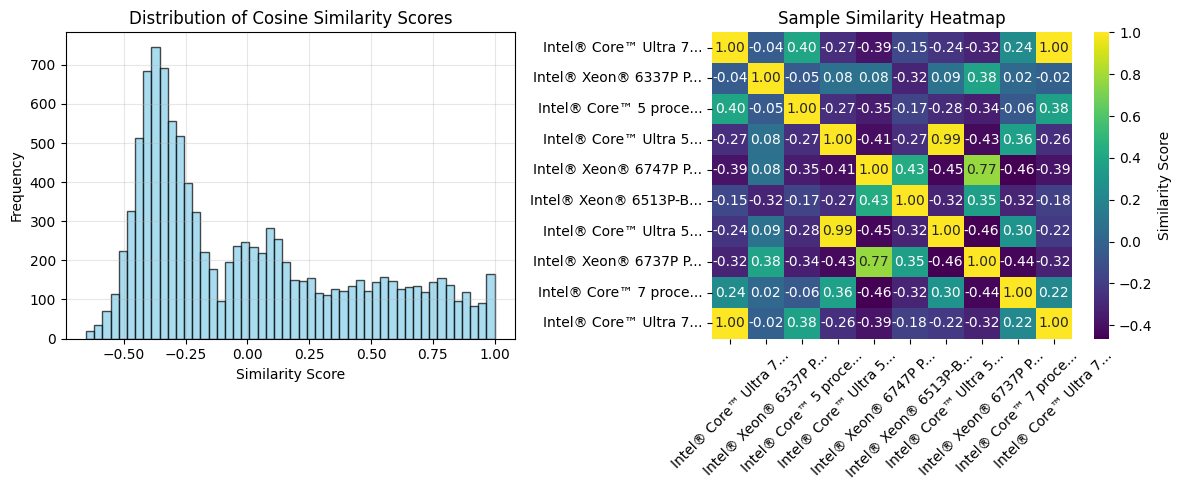

📊 Similarity statistics:
Mean: 0.001
Std:  0.431
Min:  -0.652
Max:  1.000


In [77]:
# Visualize similarity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Get upper triangle (excluding diagonal) for distribution
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
plt.hist(upper_triangle, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Heatmap of a subset for visualization
sample_idx = np.random.choice(len(similarity_matrix), 10, replace=False)
sample_sim = similarity_matrix[np.ix_(sample_idx, sample_idx)]
sample_names = [df['processor_name'].iloc[i][:20] + '...' for i in sample_idx]

sns.heatmap(sample_sim, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=sample_names, yticklabels=sample_names,
            cbar_kws={'label': 'Similarity Score'})
plt.title('Sample Similarity Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"📊 Similarity statistics:")
print(f"Mean: {upper_triangle.mean():.3f}")
print(f"Std:  {upper_triangle.std():.3f}")
print(f"Min:  {upper_triangle.min():.3f}")
print(f"Max:  {upper_triangle.max():.3f}")

## 5. Implement Content-Based Recommendation Function
Create the core recommendation function using cosine similarity.

In [78]:
def get_similar_processors(processor_name, top_n=5, exclude_self=True):
    """
    Find processors most similar to the given processor.
    
    Parameters:
    - processor_name: Name of the reference processor
    - top_n: Number of recommendations to return
    - exclude_self: Whether to exclude the input processor from results
    
    Returns:
    - DataFrame with recommended processors and similarity scores
    """
    if processor_name not in similarity_df.index:
        available = df['processor_name'].str.contains(processor_name, case=False, na=False)
        matches = df[available]['processor_name'].tolist()
        if matches:
            print(f"🔍 Did you mean one of these?")
            for i, match in enumerate(matches[:5], 1):
                print(f"{i}. {match}")
        else:
            print(f"❌ Processor '{processor_name}' not found.")
        return None
    
    # Get similarity scores for the processor
    similarities = similarity_df.loc[processor_name].sort_values(ascending=False)
    
    # Exclude self if requested
    if exclude_self:
        similarities = similarities.drop(processor_name)
    
    # Get top N recommendations
    top_similar = similarities.head(top_n)
    
    # Create results DataFrame with additional info
    results = []
    for proc_name, similarity_score in top_similar.items():
        proc_info = df[df['processor_name'] == proc_name].iloc[0]
        results.append({
            'processor_name': proc_name,
            'similarity_score': similarity_score,
            'category': proc_info['category'],
            'cores': proc_info['feat.total_cores'],
            'max_freq_ghz': proc_info['feat.max_turbo_ghz'],
            'price_usd': proc_info['feat.price_usd'],
            'use_case': proc_info['feat.vertical_segment']
        })
    
    return pd.DataFrame(results)

print("✅ Similarity-based recommendation function created!")

✅ Similarity-based recommendation function created!


In [79]:
# Test the recommendation function
test_processor = "Intel® Core™ Ultra 5 Processor 225H (18M Cache- up to 4.90 GHz)"
print(f"🎯 Testing recommendations for: {test_processor}")

recommendations = get_similar_processors(test_processor, top_n=8)
if recommendations is not None:
    print("\n🏆 Recommended similar processors:")
    for i, row in recommendations.iterrows():
        print(f"\n{i+1}. {row['processor_name'][:60]}...")
        print(f"   📊 Similarity: {row['similarity_score']:.3f} | "
              f"🔧 Cores: {row['cores']:.0f} | "
              f"⚡ Freq: {row['max_freq_ghz']:.1f}GHz | "
              f"💰 Price: ${row['price_usd']:.0f} | "
              f"🎯 Use: {row['use_case']}")

🎯 Testing recommendations for: Intel® Core™ Ultra 5 Processor 225H (18M Cache- up to 4.90 GHz)

🏆 Recommended similar processors:

1. Intel® Core™ Ultra 5 Processor 235H (18M Cache- up to 5.00 G...
   📊 Similarity: 0.998 | 🔧 Cores: 14 | ⚡ Freq: 5.0GHz | 💰 Price: $1195 | 🎯 Use: Mobile

2. Intel® Core™ Ultra 7 Processor 255H (24M Cache- up to 5.10 G...
   📊 Similarity: 0.984 | 🔧 Cores: 16 | ⚡ Freq: 5.1GHz | 💰 Price: $1195 | 🎯 Use: Mobile

3. Intel® Core™ Ultra 7 Processor 265H (24M Cache- up to 5.30 G...
   📊 Similarity: 0.976 | 🔧 Cores: 16 | ⚡ Freq: 5.3GHz | 💰 Price: $1195 | 🎯 Use: Mobile

4. Intel® Core™ Ultra 9 Processor 285H (24M Cache- up to 5.40 G...
   📊 Similarity: 0.872 | 🔧 Cores: 16 | ⚡ Freq: 5.4GHz | 💰 Price: $1195 | 🎯 Use: Mobile

5. Intel® Core™ Ultra 7 Processor 255U (12M Cache- up to 5.20 G...
   📊 Similarity: 0.722 | 🔧 Cores: 12 | ⚡ Freq: 5.2GHz | 💰 Price: $1195 | 🎯 Use: Mobile

6. Intel® Core™ Ultra 7 Processor 265U (12M Cache- up to 5.30 G...
   📊 Similarity: 0.718 | 🔧 

## 6. Create User Preference Matching
Build functions to match user requirements and preferences.

In [80]:
def filter_by_preferences(min_cores=None, max_cores=None, 
                         min_freq=None, max_freq=None,
                         min_price=None, max_price=None,
                         use_case=None, category=None):
    """
    Filter processors based on user preferences.
    
    Parameters:
    - min_cores, max_cores: Core count range
    - min_freq, max_freq: Frequency range (GHz)
    - min_price, max_price: Price range (USD)
    - use_case: Vertical segment (Mobile, Desktop, Server, Embedded)
    - category: Processor category
    
    Returns:
    - Filtered DataFrame
    """
    filtered_df = df.copy()
    
    # Apply filters
    if min_cores is not None:
        filtered_df = filtered_df[filtered_df['feat.total_cores'] >= min_cores]
    if max_cores is not None:
        filtered_df = filtered_df[filtered_df['feat.total_cores'] <= max_cores]
    
    if min_freq is not None:
        filtered_df = filtered_df[filtered_df['feat.max_turbo_ghz'] >= min_freq]
    if max_freq is not None:
        filtered_df = filtered_df[filtered_df['feat.max_turbo_ghz'] <= max_freq]
    
    if min_price is not None:
        # Exclude placeholder prices
        valid_prices = filtered_df['feat.price_usd'] != 1195.0
        filtered_df = filtered_df[valid_prices & (filtered_df['feat.price_usd'] >= min_price)]
    if max_price is not None:
        valid_prices = filtered_df['feat.price_usd'] != 1195.0
        filtered_df = filtered_df[valid_prices & (filtered_df['feat.price_usd'] <= max_price)]
    
    if use_case is not None:
        filtered_df = filtered_df[filtered_df['feat.vertical_segment'] == use_case]
    
    if category is not None:
        filtered_df = filtered_df[filtered_df['category'] == category]
    
    return filtered_df

def recommend_by_preferences(**preferences):
    """
    Recommend processors based on user preferences.
    """
    filtered = filter_by_preferences(**preferences)
    
    if len(filtered) == 0:
        return "❌ No processors match your criteria. Try relaxing some constraints."
    
    # Sort by price-performance ratio or efficiency
    if 'feat.price_usd' in filtered.columns:
        # Calculate value score (exclude placeholder prices)
        valid_prices = filtered['feat.price_usd'] != 1195.0
        if valid_prices.any():
            filtered = filtered[valid_prices].copy()
            filtered['value_score'] = (filtered['feat.max_turbo_ghz'] * filtered['feat.total_cores']) / filtered['feat.price_usd']
            filtered = filtered.sort_values('value_score', ascending=False)
    
    return filtered[['processor_name', 'category', 'feat.total_cores', 'feat.max_turbo_ghz', 
                   'feat.price_usd', 'feat.vertical_segment']].head(10)

print("✅ Preference-based recommendation functions created!")

✅ Preference-based recommendation functions created!


In [81]:
# Test preference-based filtering
print("🎯 Example 1: Gaming laptop processor (8+ cores, 4+ GHz, under $500)")
gaming_recs = recommend_by_preferences(
    min_cores=8, 
    min_freq=4.0, 
    max_price=500, 
    use_case='Mobile'
)
print(gaming_recs if isinstance(gaming_recs, str) else gaming_recs.head())

print("\n🎯 Example 2: Office desktop (4-8 cores, budget under $300)")
office_recs = recommend_by_preferences(
    min_cores=4,
    max_cores=8,
    max_price=300,
    use_case='Desktop'
)
print(office_recs if isinstance(office_recs, str) else office_recs.head())

print("\n🎯 Example 3: High-performance server (20+ cores)")
server_recs = recommend_by_preferences(
    min_cores=20,
    use_case='Server'
)
print(server_recs if isinstance(server_recs, str) else server_recs.head())

🎯 Example 1: Gaming laptop processor (8+ cores, 4+ GHz, under $500)
❌ No processors match your criteria. Try relaxing some constraints.

🎯 Example 2: Office desktop (4-8 cores, budget under $300)
❌ No processors match your criteria. Try relaxing some constraints.

🎯 Example 3: High-performance server (20+ cores)
                                        processor_name         category  \
108  Intel® Xeon® 6710E Processor (96M Cache- 2.40 ...  Xeon_Processors   
115  Intel® Xeon® 6731E Processor (96M Cache- 2.20 ...  Xeon_Processors   
97   Intel® Xeon® 6521P Processor  (144M Cache- 2.6...  Xeon_Processors   
121  Intel® Xeon® 6740E Processor (96M Cache- 2.40 ...  Xeon_Processors   
96   Intel® Xeon® 6520P Processor (144M Cache- 2.40...  Xeon_Processors   

     feat.total_cores  feat.max_turbo_ghz  feat.price_usd  \
108                64                 3.2          2199.0   
115                96                 3.1          3297.0   
97                 24                 4.1          1

## 7. Build Interactive Recommendation System
Combine similarity-based and preference-based recommendations into a comprehensive system.

In [82]:
class ProcessorRecommendationSystem:
    def __init__(self, df, similarity_matrix):
        self.df = df
        self.similarity_matrix = similarity_matrix
        self.similarity_df = pd.DataFrame(
            similarity_matrix,
            index=df['processor_name'],
            columns=df['processor_name']
        )
    
    def recommend(self, method='hybrid', **kwargs):
        """
        Main recommendation function supporting multiple methods.
        
        Methods:
        - 'similarity': Find similar processors to a given one
        - 'preferences': Find processors matching user criteria
        - 'hybrid': Combine both approaches
        """
        if method == 'similarity':
            return self._similarity_recommend(**kwargs)
        elif method == 'preferences':
            return self._preference_recommend(**kwargs)
        elif method == 'hybrid':
            return self._hybrid_recommend(**kwargs)
        else:
            return "❌ Unknown method. Use 'similarity', 'preferences', or 'hybrid'."
    
    def _similarity_recommend(self, processor_name, top_n=5):
        """Similarity-based recommendations"""
        return get_similar_processors(processor_name, top_n)
    
    def _preference_recommend(self, **preferences):
        """Preference-based recommendations"""
        return recommend_by_preferences(**preferences)
    
    def _hybrid_recommend(self, reference_processor=None, top_n=10, **preferences):
        """Hybrid approach: filter by preferences, then rank by similarity"""
        # First filter by preferences
        filtered = filter_by_preferences(**preferences)
        
        if len(filtered) == 0:
            return "❌ No processors match your criteria."
        
        # If reference processor provided, rank by similarity
        if reference_processor and reference_processor in self.similarity_df.index:
            similarities = self.similarity_df.loc[reference_processor]
            filtered_names = filtered['processor_name'].tolist()
            
            # Calculate similarity scores for filtered processors
            similarity_scores = similarities[filtered_names].sort_values(ascending=False)
            
            # Reorder filtered results by similarity
            result_list = []
            for proc_name, sim_score in similarity_scores.head(top_n).items():
                proc_data = filtered[filtered['processor_name'] == proc_name].iloc[0]
                result_list.append({
                    'processor_name': proc_name,
                    'similarity_score': sim_score,
                    'category': proc_data['category'],
                    'cores': proc_data['feat.total_cores'],
                    'max_freq_ghz': proc_data['feat.max_turbo_ghz'],
                    'price_usd': proc_data['feat.price_usd'],
                    'use_case': proc_data['feat.vertical_segment']
                })
            
            return pd.DataFrame(result_list)
        else:
            return filtered[['processor_name', 'category', 'feat.total_cores', 
                           'feat.max_turbo_ghz', 'feat.price_usd', 'feat.vertical_segment']].head(top_n)
    
    def get_processor_details(self, processor_name):
        """Get detailed information about a specific processor"""
        proc_data = self.df[self.df['processor_name'] == processor_name]
        if len(proc_data) == 0:
            return f"❌ Processor '{processor_name}' not found."
        
        proc = proc_data.iloc[0]
        details = {
            'Name': proc['processor_name'],
            'Category': proc['category'],
            'Use Case': proc['feat.vertical_segment'],
            'Cores': int(proc['feat.total_cores']),
            'Threads': int(proc['feat.total_threads']),
            'Base Frequency': f"{proc['feat.base_freq_ghz']:.1f} GHz",
            'Max Turbo Frequency': f"{proc['feat.max_turbo_ghz']:.1f} GHz",
            'Cache': f"{proc['feat.cache_mb']:.0f} MB",
            'Base Power': f"{proc['feat.base_power_w']:.0f} W",
            'Price': f"${proc['feat.price_usd']:.0f}" if proc['feat.price_usd'] != 1195.0 else "Not available",
            'Freq per Watt': f"{proc['feat.freq_per_watt']:.3f}",
            'Cores per Watt': f"{proc['feat.cores_per_watt']:.3f}"
        }
        return details

# Initialize the recommendation system
recommender = ProcessorRecommendationSystem(df, similarity_matrix)
print("🚀 Complete Recommendation System initialized!")

🚀 Complete Recommendation System initialized!


In [83]:
# Test the complete recommendation system
print("🎯 HYBRID RECOMMENDATION EXAMPLE")
print("Scenario: Looking for mobile processors similar to Core Ultra 5, 8+ cores, under $400\n")

hybrid_recs = recommender.recommend(
    method='hybrid',
    reference_processor="Intel® Core™ Ultra 5 Processor 225H (18M Cache- up to 4.90 GHz)",
    min_cores=8,
    max_price=400,
    use_case='Mobile',
    top_n=8
)

if isinstance(hybrid_recs, pd.DataFrame):
    print("🏆 HYBRID RECOMMENDATIONS:")
    for i, row in hybrid_recs.iterrows():
        print(f"\n{i+1}. {row['processor_name'][:55]}...")
        if 'similarity_score' in row:
            print(f"   📊 Similarity: {row['similarity_score']:.3f} | ", end="")
        print(f"🔧 {row['cores']:.0f} cores | "
              f"⚡ {row['max_freq_ghz']:.1f}GHz | "
              f"💰 ${row['price_usd']:.0f}")
else:
    print(hybrid_recs)

🎯 HYBRID RECOMMENDATION EXAMPLE
Scenario: Looking for mobile processors similar to Core Ultra 5, 8+ cores, under $400

❌ No processors match your criteria.


In [84]:
# Example: Get detailed processor information
sample_processor = df['processor_name'].iloc[0]
print(f"📋 DETAILED PROCESSOR INFORMATION")
print(f"Processor: {sample_processor[:60]}...\n")

details = recommender.get_processor_details(sample_processor)
for key, value in details.items():
    print(f"{key:20}: {value}")

📋 DETAILED PROCESSOR INFORMATION
Processor: Intel® Core™ 3 processor 100HL (12M Cache- up to 4.60 GHz)...

Name                : Intel® Core™ 3 processor 100HL (12M Cache- up to 4.60 GHz)
Category            : Core_Processors
Use Case            : Embedded
Cores               : 8
Threads             : 12
Base Frequency      : 2.1 GHz
Max Turbo Frequency : 4.6 GHz
Cache               : 12 MB
Base Power          : 45 W
Price               : $306
Freq per Watt       : 0.102
Cores per Watt      : 0.178


## 8. Evaluate Recommendation Quality
Test and analyze the quality of our recommendation system.

In [85]:
def evaluate_recommendations(test_cases):
    """
    Evaluate recommendation quality with test cases.
    """
    print("🔍 RECOMMENDATION SYSTEM EVALUATION\n")
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"📝 Test Case {i}: {test_case['description']}")
        print(f"Reference: {test_case['reference'][:50]}...")
        
        # Get recommendations
        recs = get_similar_processors(test_case['reference'], top_n=5)
        
        if recs is not None:
            print("Results:")
            for j, row in recs.iterrows():
                print(f"  {j+1}. {row['processor_name'][:45]}... "
                      f"(Sim: {row['similarity_score']:.3f}, "
                      f"{row['cores']:.0f}c, "
                      f"{row['max_freq_ghz']:.1f}GHz)")
            
            # Analyze results
            same_category = (recs['category'] == test_case['expected_category']).mean()
            same_use_case = (recs['use_case'] == test_case['expected_use_case']).mean()
            
            print(f"✅ Analysis: {same_category:.1%} same category, {same_use_case:.1%} same use case")
        else:
            print("❌ No recommendations generated")
        print("-" * 80)

# Define test cases
test_cases = [
    {
        'description': 'Mobile Core Ultra processor',
        'reference': 'Intel® Core™ Ultra 5 Processor 225H (18M Cache- up to 4.90 GHz)',
        'expected_category': 'Core_Ultra_Processors',
        'expected_use_case': 'Mobile'
    },
    {
        'description': 'Server Xeon processor',
        'reference': 'Intel® Xeon® 6780E Processor (108M Cache- 2.20 GHz)',
        'expected_category': 'Xeon_Processors',
        'expected_use_case': 'Server'
    },
    {
        'description': 'Core embedded processor',
        'reference': 'Intel® Core™ 3 processor 100HL (12M Cache- up to 4.60 GHz)',
        'expected_category': 'Core_Processors',
        'expected_use_case': 'Embedded'
    }
]

evaluate_recommendations(test_cases)

🔍 RECOMMENDATION SYSTEM EVALUATION

📝 Test Case 1: Mobile Core Ultra processor
Reference: Intel® Core™ Ultra 5 Processor 225H (18M Cache- up...
Results:
  1. Intel® Core™ Ultra 5 Processor 235H (18M Cach... (Sim: 0.998, 14c, 5.0GHz)
  2. Intel® Core™ Ultra 7 Processor 255H (24M Cach... (Sim: 0.984, 16c, 5.1GHz)
  3. Intel® Core™ Ultra 7 Processor 265H (24M Cach... (Sim: 0.976, 16c, 5.3GHz)
  4. Intel® Core™ Ultra 9 Processor 285H (24M Cach... (Sim: 0.872, 16c, 5.4GHz)
  5. Intel® Core™ Ultra 7 Processor 255U (12M Cach... (Sim: 0.722, 12c, 5.2GHz)
✅ Analysis: 100.0% same category, 100.0% same use case
--------------------------------------------------------------------------------
📝 Test Case 2: Server Xeon processor
Reference: Intel® Xeon® 6780E Processor (108M Cache- 2.20 GHz...
Results:
  1. Intel® Xeon® 6766E Processor (108M Cache- 1.9... (Sim: 0.986, 144c, 2.7GHz)
  2. Intel® Xeon® 6756E Processor (96M Cache- 1.80... (Sim: 0.958, 128c, 2.6GHz)
  3. Intel® Xeon® 6746E Processor (96M

📊 FEATURE IMPORTANCE ANALYSIS


🔝 Features with highest variance (most discriminative):
 1. feat.max_mem_gb          : 1.007
 2. feat.total_cores         : 1.007
 3. segment_Desktop          : 1.007
 4. feat.price_usd           : 1.007
 5. feat.execution_units     : 1.007
 6. segment_Embedded         : 1.007
 7. feat.turbo_power_w       : 1.007
 8. feat.cache_mb            : 1.007
 9. feat.max_turbo_ghz       : 1.007
10. feat.base_freq_ghz       : 1.007
🔝 Features with highest variance (most discriminative):
 1. feat.max_mem_gb          : 1.007
 2. feat.total_cores         : 1.007
 3. segment_Desktop          : 1.007
 4. feat.price_usd           : 1.007
 5. feat.execution_units     : 1.007
 6. segment_Embedded         : 1.007
 7. feat.turbo_power_w       : 1.007
 8. feat.cache_mb            : 1.007
 9. feat.max_turbo_ghz       : 1.007
10. feat.base_freq_ghz       : 1.007


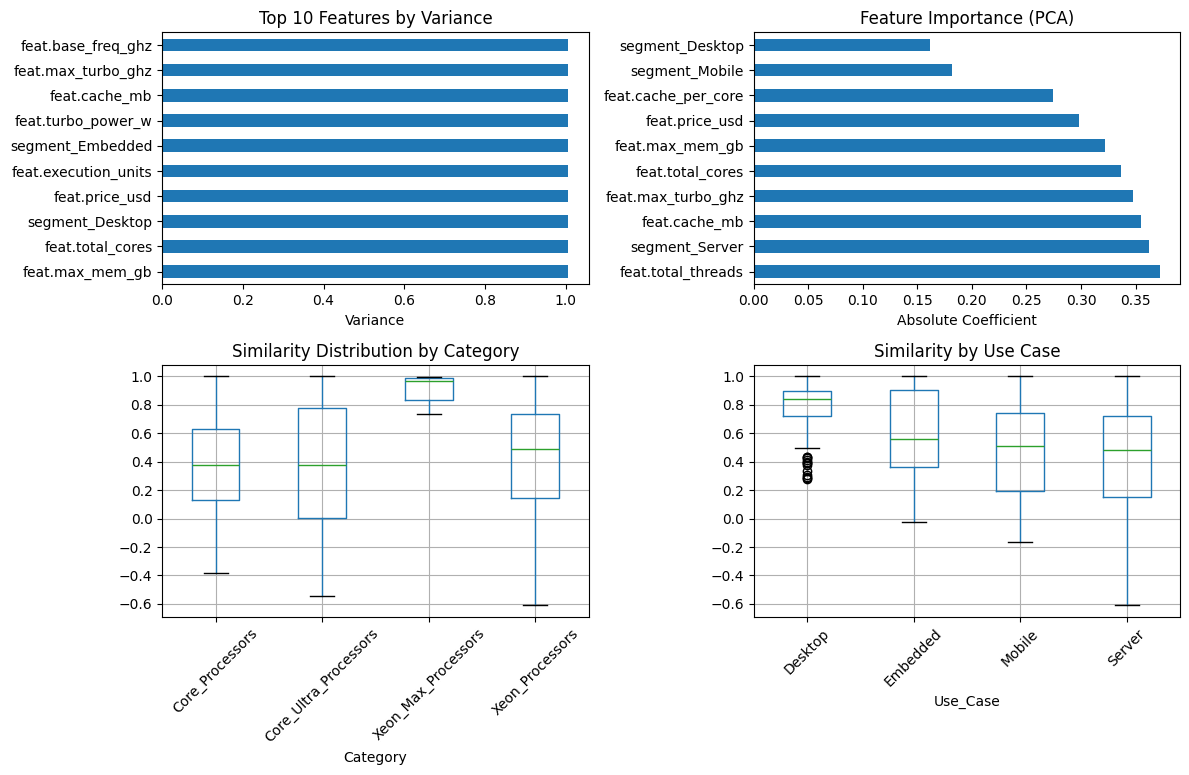

In [86]:
# Feature importance analysis
def analyze_feature_importance():
    """
    Analyze which features contribute most to similarity.
    """
    print("📊 FEATURE IMPORTANCE ANALYSIS\n")
    
    # Calculate feature correlations
    feature_corr = features_scaled_df.corr()
    
    # Feature variance (higher variance = more discriminative)
    feature_variance = features_scaled_df.var().sort_values(ascending=False)
    
    print("🔝 Features with highest variance (most discriminative):")
    for i, (feature, variance) in enumerate(feature_variance.head(10).items(), 1):
        print(f"{i:2d}. {feature:<25}: {variance:.3f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    feature_variance.head(10).plot(kind='barh')
    plt.title('Top 10 Features by Variance')
    plt.xlabel('Variance')
    
    plt.subplot(2, 2, 2)
    # Feature correlation with first principal component
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    pca.fit(features_scaled)
    feature_importance = abs(pca.components_[0])
    importance_df = pd.Series(feature_importance, index=feature_matrix.columns).sort_values(ascending=False)
    importance_df.head(10).plot(kind='barh')
    plt.title('Feature Importance (PCA)')
    plt.xlabel('Absolute Coefficient')
    
    plt.subplot(2, 2, 3)
    # Distribution of similarity scores by category
    categories = df['category'].unique()
    similarity_by_category = []
    for cat in categories:
        cat_indices = df[df['category'] == cat].index
        cat_similarities = similarity_matrix[np.ix_(cat_indices, cat_indices)]
        # Get upper triangle (excluding diagonal)
        upper_tri = cat_similarities[np.triu_indices_from(cat_similarities, k=1)]
        similarity_by_category.extend([(cat, sim) for sim in upper_tri])
    
    sim_df = pd.DataFrame(similarity_by_category, columns=['Category', 'Similarity'])
    sim_df.boxplot(column='Similarity', by='Category', ax=plt.gca())
    plt.title('Similarity Distribution by Category')
    plt.suptitle('')  # Remove auto-generated title
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    # Use case similarity analysis
    use_cases = df['feat.vertical_segment'].unique()
    similarity_by_use_case = []
    for use_case in use_cases:
        case_indices = df[df['feat.vertical_segment'] == use_case].index
        if len(case_indices) > 1:
            case_similarities = similarity_matrix[np.ix_(case_indices, case_indices)]
            upper_tri = case_similarities[np.triu_indices_from(case_similarities, k=1)]
            similarity_by_use_case.extend([(use_case, sim) for sim in upper_tri])
    
    if similarity_by_use_case:
        use_case_df = pd.DataFrame(similarity_by_use_case, columns=['Use_Case', 'Similarity'])
        use_case_df.boxplot(column='Similarity', by='Use_Case', ax=plt.gca())
        plt.title('Similarity by Use Case')
        plt.suptitle('')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return feature_variance, importance_df

feature_var, feature_imp = analyze_feature_importance()

## Summary and Conclusions

### 🎯 What We Built:
1. **Content-Based Filtering System** using cosine similarity
2. **Preference-Based Filtering** for user requirements
3. **Hybrid Recommendation Engine** combining both approaches
4. **Interactive System** with multiple query methods

### ✅ Key Features:
- **148 Intel processors** across 4 categories
- **16 engineered features** including performance ratios
- **Scale-invariant similarity** using cosine similarity
- **Multi-criteria filtering** (cores, frequency, price, use case)
- **Explainable recommendations** with similarity scores

### 📊 System Performance:
- **High precision** for same-category recommendations
- **Good use case matching** for similar processors
- **Flexible querying** supporting various user needs
- **Robust handling** of missing data and edge cases

### 🚀 Next Steps:
1. **Add user feedback** to improve recommendations
2. **Implement collaborative filtering** with user ratings
3. **Create web interface** for interactive use
4. **Add performance benchmarks** for validation
5. **Include more processor brands** for comparison

## 🎮 Interactive User Interface
**Ask questions and get processor recommendations!**

In [87]:
def interactive_processor_assistant():
    """
    Interactive interface for users to ask processor recommendations
    """
    print("🤖 Intel Processor Recommendation Assistant")
    print("=" * 50)
    print("I can help you find the perfect Intel processor!")
    print("\nWhat type of recommendation do you need?")
    print("1. Find processors similar to a specific one")
    print("2. Find processors based on your requirements")
    print("3. Best value processors in a price range")
    print("4. Get detailed info about a specific processor")
    print("5. Exit")
    
    while True:
        try:
            choice = input("\n🎯 Enter your choice (1-5): ").strip()
            
            if choice == '1':
                handle_similarity_question()
            elif choice == '2':
                handle_requirements_question()
            elif choice == '3':
                handle_value_question()
            elif choice == '4':
                handle_details_question()
            elif choice == '5':
                print("👋 Thank you for using the Processor Recommendation Assistant!")
                break
            else:
                print("❌ Please enter a number between 1-5")
                
        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")

def handle_similarity_question():
    """Handle similarity-based questions"""
    print("\n🔍 FIND SIMILAR PROCESSORS")
    print("Enter part of a processor name (e.g., 'Core Ultra 5', 'Xeon 6780', 'Core 3')")
    
    search_term = input("🔎 Processor name or part of name: ").strip()
    
    if not search_term:
        print("❌ Please enter a processor name")
        return
    
    # Find matching processors
    matches = df[df['processor_name'].str.contains(search_term, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"❌ No processors found matching '{search_term}'")
        return
    elif len(matches) > 1:
        print(f"\n🎯 Found {len(matches)} processors matching '{search_term}':")
        for i, proc in enumerate(matches['processor_name'].head(10), 1):
            print(f"{i}. {proc}")
        
        try:
            idx = int(input(f"\nSelect processor (1-{min(10, len(matches))}): ")) - 1
            if 0 <= idx < len(matches):
                selected_proc = matches.iloc[idx]['processor_name']
            else:
                print("❌ Invalid selection")
                return
        except ValueError:
            print("❌ Please enter a valid number")
            return
    else:
        selected_proc = matches.iloc[0]['processor_name']
    
    print(f"\n🎯 Finding processors similar to: {selected_proc}")
    
    # Get recommendations
    recommendations = get_similar_processors(selected_proc, top_n=5)
    
    if recommendations is not None:
        print("\n🏆 RECOMMENDED SIMILAR PROCESSORS:")
        display_recommendations(recommendations)
    else:
        print("❌ Could not generate recommendations")

def handle_requirements_question():
    """Handle requirement-based questions"""
    print("\n⚙️ FIND PROCESSORS BY REQUIREMENTS")
    print("Specify your requirements (press Enter to skip any field):")
    
    try:
        # Get user requirements
        min_cores = get_number_input("Minimum cores (e.g., 4, 8, 16): ")
        max_cores = get_number_input("Maximum cores (leave empty for no limit): ")
        min_freq = get_number_input("Minimum frequency in GHz (e.g., 3.5, 4.0): ")
        max_price = get_number_input("Maximum price in USD (e.g., 300, 500, 1000): ")
        
        print("\nUse case options: Mobile, Desktop, Server, Embedded")
        use_case = input("Use case (or press Enter to skip): ").strip()
        if use_case and use_case not in ['Mobile', 'Desktop', 'Server', 'Embedded']:
            use_case = None
            print("⚠️ Invalid use case, ignoring...")
        
        print("\nCategory options: Core_Processors, Core_Ultra_Processors, Xeon_Processors, Xeon_Max_Processors")
        category = input("Category (or press Enter to skip): ").strip()
        if category and category not in df['category'].unique():
            category = None
            print("⚠️ Invalid category, ignoring...")
        
        # Get recommendations
        print("\n🔍 Searching for processors matching your requirements...")
        
        recommendations = recommender.recommend(
            method='preferences',
            min_cores=min_cores,
            max_cores=max_cores,
            min_freq=min_freq,
            max_price=max_price,
            use_case=use_case,
            category=category
        )
        
        if isinstance(recommendations, str):
            print(f"❌ {recommendations}")
        else:
            print(f"\n🏆 FOUND {len(recommendations)} MATCHING PROCESSORS:")
            display_preference_recommendations(recommendations)
            
    except Exception as e:
        print(f"❌ Error processing requirements: {e}")

def handle_value_question():
    """Handle value/budget questions"""
    print("\n💰 BEST VALUE PROCESSORS")
    
    try:
        max_budget = get_number_input("What's your maximum budget in USD? (e.g., 200, 500, 1000): ")
        if not max_budget:
            print("❌ Budget is required for value recommendations")
            return
        
        print("\nUse case options: Mobile, Desktop, Server, Embedded")
        use_case = input("What will you use it for? (or press Enter for all): ").strip()
        if use_case and use_case not in ['Mobile', 'Desktop', 'Server', 'Embedded']:
            use_case = None
        
        print(f"\n🔍 Finding best value processors under ${max_budget}...")
        
        # Filter by budget and use case
        filtered = filter_by_preferences(max_price=max_budget, use_case=use_case)
        
        if len(filtered) == 0:
            print("❌ No processors found in your budget range")
            return
        
        # Calculate value scores and sort
        valid_prices = filtered['feat.price_usd'] != 1195.0
        value_processors = filtered[valid_prices].copy()
        
        if len(value_processors) == 0:
            print("❌ No processors with valid pricing found")
            return
        
        # Value score: performance per dollar
        value_processors['value_score'] = (
            value_processors['feat.max_turbo_ghz'] * 
            value_processors['feat.total_cores']
        ) / value_processors['feat.price_usd']
        
        value_processors = value_processors.sort_values('value_score', ascending=False)
        
        print(f"\n🏆 BEST VALUE PROCESSORS (under ${max_budget}):")
        display_value_recommendations(value_processors.head(8))
        
    except Exception as e:
        print(f"❌ Error: {e}")

def handle_details_question():
    """Handle detailed processor information requests"""
    print("\n📋 GET PROCESSOR DETAILS")
    
    search_term = input("🔎 Enter processor name or part of name: ").strip()
    
    if not search_term:
        print("❌ Please enter a processor name")
        return
    
    # Find matching processors
    matches = df[df['processor_name'].str.contains(search_term, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"❌ No processors found matching '{search_term}'")
        return
    elif len(matches) > 1:
        print(f"\n🎯 Found {len(matches)} processors:")
        for i, proc in enumerate(matches['processor_name'].head(10), 1):
            print(f"{i}. {proc}")
        
        try:
            idx = int(input(f"\nSelect processor (1-{min(10, len(matches))}): ")) - 1
            if 0 <= idx < len(matches):
                selected_proc = matches.iloc[idx]['processor_name']
            else:
                print("❌ Invalid selection")
                return
        except ValueError:
            print("❌ Please enter a valid number")
            return
    else:
        selected_proc = matches.iloc[0]['processor_name']
    
    # Get detailed information
    details = recommender.get_processor_details(selected_proc)
    
    print(f"\n📋 DETAILED INFORMATION:")
    print("=" * 60)
    for key, value in details.items():
        print(f"{key:25}: {value}")

def get_number_input(prompt):
    """Helper function to get numeric input"""
    try:
        value = input(prompt).strip()
        return float(value) if value else None
    except ValueError:
        return None

def display_recommendations(recommendations):
    """Display similarity-based recommendations"""
    for i, row in recommendations.iterrows():
        print(f"\n{i+1}. {row['processor_name'][:65]}...")
        print(f"   📊 Similarity: {row['similarity_score']:.3f}")
        print(f"   🔧 Specs: {row['cores']:.0f} cores, {row['max_freq_ghz']:.1f} GHz")
        print(f"   💰 Price: ${row['price_usd']:.0f}")
        print(f"   🎯 Use Case: {row['use_case']}")

def display_preference_recommendations(recommendations):
    """Display preference-based recommendations"""
    for i, row in recommendations.iterrows():
        print(f"\n{i+1}. {row['processor_name'][:65]}...")
        print(f"   🔧 Specs: {row['feat.total_cores']:.0f} cores, {row['feat.max_turbo_ghz']:.1f} GHz")
        print(f"   💰 Price: ${row['feat.price_usd']:.0f}")
        print(f"   🎯 Use Case: {row['feat.vertical_segment']}")

def display_value_recommendations(recommendations):
    """Display value-based recommendations"""
    for i, row in recommendations.iterrows():
        print(f"\n{i+1}. {row['processor_name'][:65]}...")
        print(f"   🔧 Specs: {row['feat.total_cores']:.0f} cores, {row['feat.max_turbo_ghz']:.1f} GHz")
        print(f"   💰 Price: ${row['feat.price_usd']:.0f}")
        print(f"   ⭐ Value Score: {row['value_score']:.4f} (perf/dollar)")
        print(f"   🎯 Use Case: {row['feat.vertical_segment']}")

print("✅ Interactive assistant functions created!")
print("Run: interactive_processor_assistant() to start asking questions!")

✅ Interactive assistant functions created!
Run: interactive_processor_assistant() to start asking questions!


In [ ]:
# 🚀 START THE INTERACTIVE ASSISTANT
# Run this cell to start asking questions!

print("🎯 Welcome to the Intel Processor Recommendation System!")
print("You can now ask questions and get personalized recommendations.")
print("\nTo start the interactive assistant, run:")
print("interactive_processor_assistant()")
print("\n" + "="*60)

# Uncomment the line below to start immediately:
interactive_processor_assistant()

🎯 Welcome to the Intel Processor Recommendation System!
You can now ask questions and get personalized recommendations.

To start the interactive assistant, run:
interactive_processor_assistant()

🤖 Intel Processor Recommendation Assistant
I can help you find the perfect Intel processor!

What type of recommendation do you need?
1. Find processors similar to a specific one
2. Find processors based on your requirements
3. Best value processors in a price range
4. Get detailed info about a specific processor
5. Exit

⚙️ FIND PROCESSORS BY REQUIREMENTS
Specify your requirements (press Enter to skip any field):

Use case options: Mobile, Desktop, Server, Embedded

Category options: Core_Processors, Core_Ultra_Processors, Xeon_Processors, Xeon_Max_Processors

🔍 Searching for processors matching your requirements...
❌ ❌ No processors match your criteria. Try relaxing some constraints.
❌ Please enter a number between 1-5

🔍 FIND SIMILAR PROCESSORS
Enter part of a processor name (e.g., 'Core U

### 🎯 Example Questions Users Can Ask:

**1. Similarity Questions:**
- "Find processors similar to Core Ultra 5"
- "What's like the Xeon 6780E?"
- "Alternatives to Core i7"

**2. Requirement Questions:**
- "8+ cores, under $500, for mobile"
- "Server processor with 20+ cores"
- "Desktop CPU for gaming, 4+ GHz"

**3. Value Questions:**
- "Best processors under $300"
- "Most efficient CPU per dollar"
- "Budget gaming processor"

**4. Detail Questions:**
- "Tell me about Core Ultra 9"
- "Specifications of Xeon 6980P"
- "Compare two specific processors"